In [2]:
# Notebook configuration
RESULTS_DIR = "./results/five/"
GT_DIR = "/mnt/nas1/fvs_benchmark_datasets"

In [3]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib widget
%matplotlib inline
import ipywidgets as widgets

In [4]:
# Load CSV
pgvector_csvs = []

for file in os.listdir(RESULTS_DIR):
    print(file)
    if file.endswith(".csv"):
        fpath = os.path.join(RESULTS_DIR, file)
        pgvector_csvs.append(fpath)
           
if len(pgvector_csvs)==0:
    raise Exception("No CSVs found in pgvector!")
print("found %d CSV files for pgvector" % len(pgvector_csvs))



pgvector_deep-20M_64_16_2.csv
pgvector_deep-50M_64_16_10.csv
pgvector_deep-5M_64_16_2.csv
pgvector_deep-20M_64_16_4.csv
pgvector_deep-20M_64_16_-1.csv
pgvector_deep-1M_64_16_16.csv
pgvector_deep-10M_64_16_8.csv
pgvector_deep-10M_64_16_2.csv
pgvector_deep-5M_64_16_-1.csv
pgvector_deep-10M_64_16_16.csv
pgvector_deep-5M_64_16_16.csv
pgvector_deep-5M_64_16_4.csv
pgvector_deep-20M_64_16_8.csv
pgvector_deep-100M_64_16_10.csv
pgvector_deep-1M_64_16_4.csv
pgvector_deep-1M_64_16_-1.csv
pgvector_deep-10M_64_16_4.csv
pgvector_deep-1M_64_16_8.csv
pgvector_deep-250M_64_16_10.csv
pgvector_deep-1M_64_16_2.csv
pgvector_deep-10M_64_16_-1.csv
pgvector_deep-20M_64_16_16.csv
pgvector_deep-5M_64_16_8.csv
found 23 CSV files for pgvector


In [5]:
# Load to df
pgvector_dfs = []

for csv in pgvector_csvs:
    df = pd.read_csv(csv, delimiter='\t')
    pgvector_dfs.append(df)

# concat into one master
print("Concatenating into one master dataframe...")
pgvector_df = pd.concat( pgvector_dfs )
print("There are %d rows" % pgvector_df.shape[0])



Concatenating into one master dataframe...
There are 92023 rows


## GT

In [6]:
def size_num(s):
    '''get raw numercs of text abbrev'''
    if s == '1M': return 1000000
    elif s == '2M': return 2000000
    elif s == '5M': return 5000000
    elif s == '10M': return 10000000
    elif s == '20M': return 20000000
    elif s == '50M': return 50000000
    elif s == '100M': return 100000000
    elif s == '200M': return 200000000
    elif s == '250M': return 250000000
    elif s == '500M': return 500000000
    elif s == '10K': return 10000
    elif s == '1000M': return 1000000000
    else: raise Exception("Unsupported size " + s)
    
def hsize(numrecs):
    '''get text abbrev of raw numrecs'''
    if numrecs==10000: return "10K"
    elif numrecs==1000000: return "1M"
    elif numrecs==2000000: return "2M"
    elif numrecs==5000000: return "5M"
    elif numrecs==10000000: return "10M"
    elif numrecs==20000000: return "20M"
    elif numrecs==50000000: return "50M"
    elif numrecs==100000000: return "100M"
    elif numrecs==250000000: return "250M"
    elif numrecs==500000000: return "500M"
    elif numrecs==1000000000: return "1000M"
    else: raise Exception("Unsupported size" + str(numrecs))
    
def compute_recall(a, b):
    '''Computes the recall metric on query results.'''

    nq, rank = a.shape
    intersect = [ np.intersect1d(a[i, :rank], b[i, :rank]).size for i in range(nq) ]
    ninter = sum( intersect )
    return ninter / a.size, intersect

In [8]:
dic = {}
recall10_mean = []
latency_mean = []
numrecs_lst = []
ef_search_lst = []
workers_lst = []

for numrecs in pgvector_df['numrecs'].unique():
    if numrecs == -1:
        continue
    
    ef_unique = pgvector_df.ef_search.unique().tolist()
    ef_unique.remove(-1)

    worker_unique = pgvector_df.workers.unique().tolist()
    worker_unique.remove(-1)

    num_records = hsize(numrecs)
    gt_file = os.path.join(GT_DIR, "deep-%s-gt-1000.npy" % num_records)
    gt = np.load(gt_file, allow_pickle=True)

    for ef_search in ef_unique:
        for w in worker_unique:

            recall_lst = []
            latency_lst = []
            
            df = pgvector_df[(pgvector_df['ef_search']== ef_search) & (pgvector_df['workers']== w) & (pgvector_df['numrecs'] == numrecs)]
            if len(df) != 1000:
                raise Exception("not equal to 1000")

            for j in range(len(df)):
                row = df.iloc[j]
                lbl = row.labels
                latency = row.walltime

                # transform lbl
                lbl_trunc = lbl[2:-2]
                lbl_converted = np.fromstring( lbl_trunc, dtype=int, sep=' ')
                lbl_reshape = lbl_converted.reshape(1, 10)
                gt_reshape = gt[j][:10].reshape(1, 10)

                # compute recall
                recall, cnt = compute_recall(gt_reshape, lbl_reshape)
                recall_lst.append(recall)
                latency_lst.append(latency)

            
            recall10_mean.append(np.mean(recall_lst))
            latency_mean.append(np.mean(latency_lst))
            numrecs_lst.append(num_records)
            ef_search_lst.append(ef_search)
            workers_lst.append(w)
            print(num_records, ef_search, w, len(recall_lst), np.mean(recall_lst), np.mean(latency_lst))

dic = {'numrecs':numrecs_lst, 'ef_search':ef_search_lst, 'workers': workers_lst, 'recall@10':recall10_mean, 'latency':latency_mean} 
result_df = pd.DataFrame(dic)
        


Exception: not equal to 1000

In [ ]:
(pgvector_df[(pgvector_df['ef_search']== ef_search) & (pgvector_df['numrecs'] == numrecs)])

5000

In [ ]:
# p90/95/99 latency, show not just mean, capture in a csv
# error bar along y axis, range, interval, stats interval, boxplots intervals, coretile analysis for recall

In [ ]:
def plot_paretto(num_records):

    df = result_df[ result_df['numrecs'] == num_records]
    print(df)

    # extract the lines for plotting
    paretto_parameters = list(df['ef_search'])
    paretto_search = list(df['latency'])
    paretto_recall = list(df['recall@10'])
    print(paretto_search, paretto_recall)


    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(paretto_search, paretto_recall, marker='x', color='blue', label='vanilla HNSW')
    
    # annotate hnsw
    for i, bits in enumerate(paretto_parameters):
        ax.annotate("ef=%d"%bits, 
                xy=(paretto_search[i],paretto_recall[i]-0.005 ), 
                xytext=(0.0,5),
                textcoords="offset points"
                )

    ax.set_xlabel("Q-by-Q Latency (milliseconds)")
    ax.set_ylabel("Recall@10")
    title = f"pgvector - {num_records} Records of Deep1B"
    plt.title(title)
    ax.legend(loc='lower right', fontsize='small')

    save_path = f'results/vis/pgvector_paretto{num_records}.png'

    fig.savefig(save_path)

    return "done"
    

  numrecs  ef_search  recall@10   latency
0     10K         64     0.9993  0.806578
1     10K        128     1.0000  1.698076
2     10K        256     1.0000  2.969329
3     10K        512     1.0000  5.484763
[0.806578, 1.698076, 2.969329, 5.484763] [0.9993000000000001, 1.0, 1.0, 1.0]
  numrecs  ef_search  recall@10    latency
4      1M         64     0.9830   9.327487
5      1M        128     0.9930  15.476113
6      1M        256     0.9972  26.342246
7      1M        512     0.9991  45.139670
[9.327487, 15.476113000000002, 26.342246, 45.139669999999995] [0.983, 0.993, 0.9972, 0.9991]
Empty DataFrame
Columns: [numrecs, ef_search, recall@10, latency]
Index: []
[] []


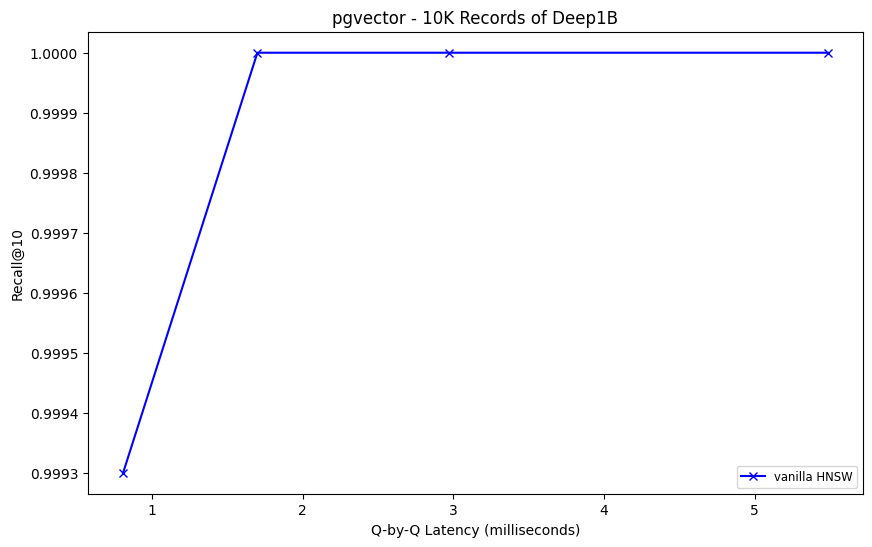

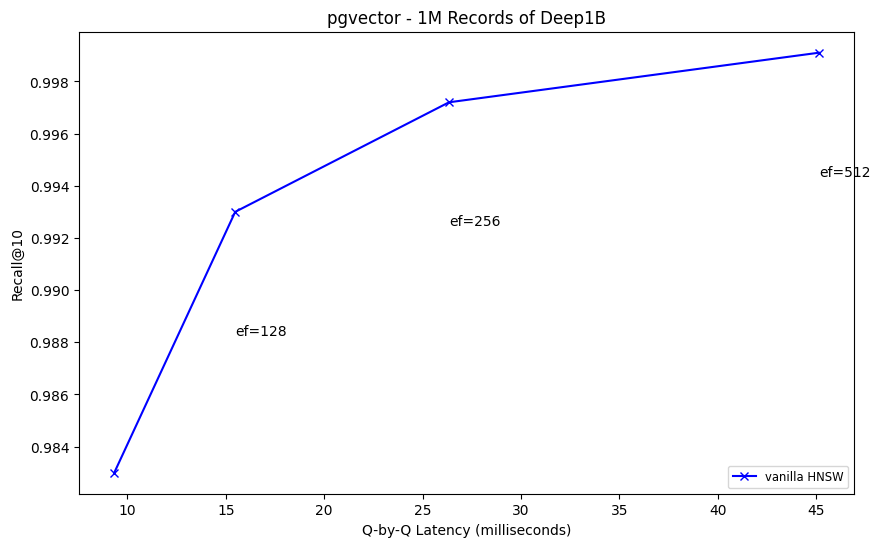

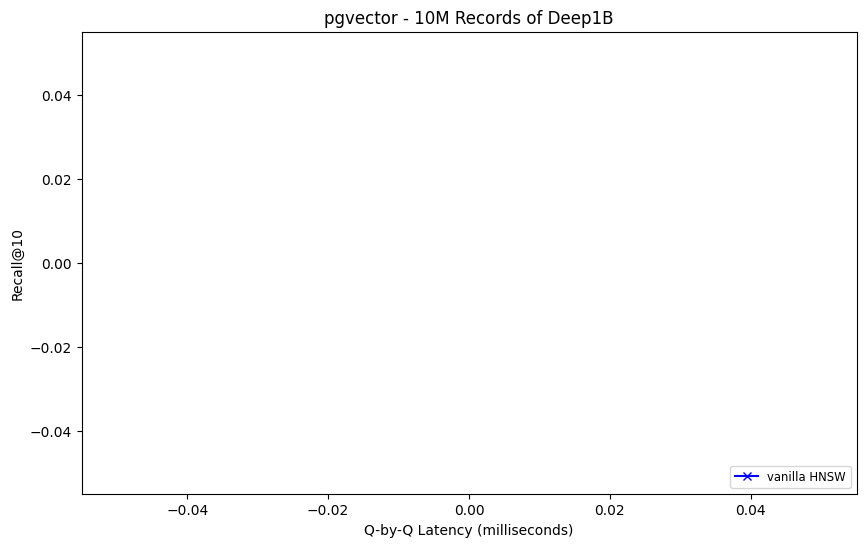

In [ ]:
lst = ['10K', '1M', '10M']#, '20M', '50M', '100M', '250M', '500M', '1000M']
for i in lst:
    plot_paretto(i)

# Index Build Time

In [6]:
df = pgvector_df[['operation', 'walltime', 'dataset', 'numrecs', 'workers']] # seconds
df = df[df['operation'] == 'build']
df = df.sort_values(by=['numrecs'])
df

,operation,walltime,dataset,numrecs,workers
0,build,357.716964,deep-1M,1000000,2
0,build,253.231867,deep-1M,1000000,8
0,build,354.299438,deep-1M,1000000,-1
0,build,297.586012,deep-1M,1000000,4
0,build,263.806457,deep-1M,1000000,16
0,build,1906.872292,deep-5M,5000000,4
0,build,1487.639595,deep-5M,5000000,16
0,build,2064.269619,deep-5M,5000000,-1
0,build,2698.225077,deep-5M,5000000,8
0,build,2087.422286,deep-5M,5000000,2


In [7]:
new_df = df[df.workers != -1]
new_df = new_df.sort_values(by=['workers'])
dd = pd.pivot_table(data=new_df, index=['numrecs'], columns=['workers'], values='walltime')
dd

workers,2,4,8,10,16
numrecs,,,,,
1000000,357.716964,297.586012,253.231867,NaN,263.806457
5000000,2087.422286,1906.872292,2698.225077,NaN,1487.639595
10000000,6347.514899,4454.487366,3787.477359,NaN,4024.020890
20000000,19521.509684,14006.014071,9898.810132,NaN,10263.123252
50000000,NaN,NaN,NaN,29977.998475,NaN
100000000,NaN,NaN,NaN,65876.278206,NaN
250000000,NaN,NaN,NaN,182289.052372,NaN


Text(0.5, 1.0, 'pgvector hnsw build time \n[ m=16, efc=64, dataset=1M of Deep-1B, dims=96, dtype=float32, \nshared_buffers=354692MB(25%), worker_mem=8GB, CPU cores=104, total RAM=1.4TB ]')

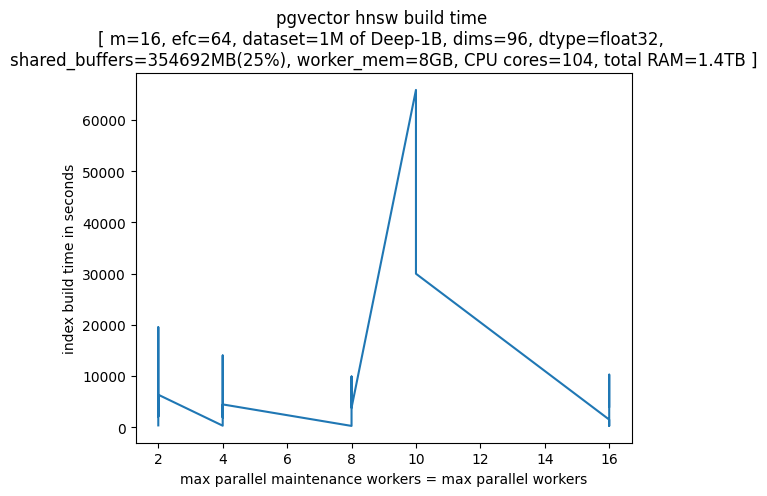

In [12]:
ax = new_df.plot.line('workers', 'walltime', legend=False)
ax.set_xlabel("max parallel maintenance workers = max parallel workers")
ax.set_ylabel("index build time in seconds")
ax.set_title("pgvector hnsw build time \n[ m=16, efc=64, dataset=1M of Deep-1B, dims=96, dtype=float32, \nshared_buffers=354692MB(25%), worker_mem=8GB, CPU cores=104, total RAM=1.4TB ]")

In [13]:
dd[2].tolist()

[357.716964, 2087.422286, 6347.514899, 19521.509684, nan, nan]

In [9]:
dd[10]

numrecs
1000000                NaN
5000000                NaN
10000000               NaN
20000000               NaN
50000000      29977.998475
100000000     65876.278206
250000000    182289.052372
Name: 10, dtype: float64

In [16]:
# numbers
# 50M, 100M
import math

# pgvector
pg_lst_hr = [29977.998475/3600, 65876.278206/3600]

# hnswlib vanilla
hnswlib_lst_hr = [766.100065/3600, 1647.981940/3600]

# gxl: 8apu
gxl_lst_hr = [403.191211/3600, 749.98961/3600]
#################################
# pgvector
# 50m, 100m, 250m
pg_lst = [29977.998475, 65876.278206, 182289.052372]

# hnswlib vanilla
hnswlib_lst = [766.100065, 1647.981940, 4441.586893]

# gxl: 15 apu
gxl_lst = [403.191211, 749.989613, 1720.912953]


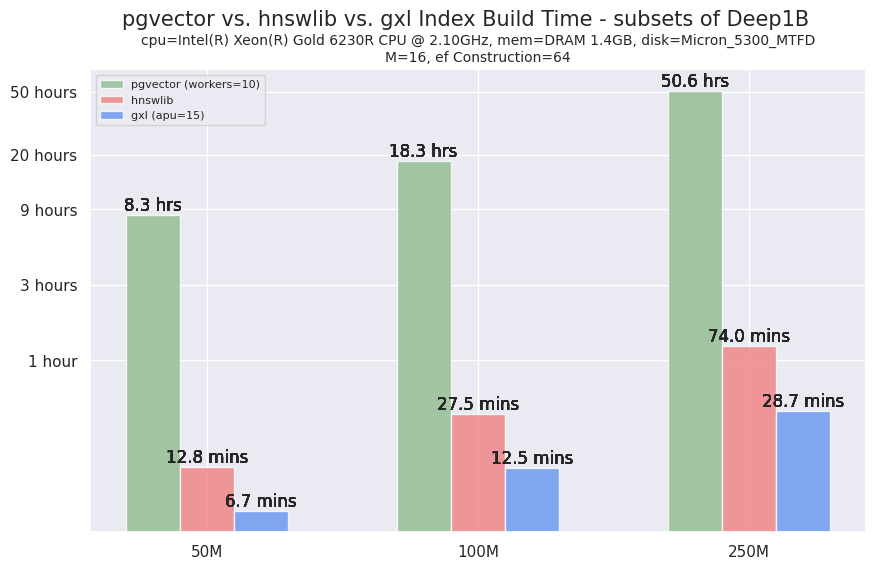

In [17]:
import seaborn as sns

# data
t1 = np.array(pg_lst)
t2 = np.array(hnswlib_lst)
t3 = np.array(gxl_lst)

# data sizes
sizes = ['50M', '100M', '250M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.2
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    
    pos1 = np.arange(len(t1))
    pos2 = pos1 + bar_width
    pos3 = pos2 + bar_width

    fig, ax = plt.subplots()
    plt.yscale("log") 

    b1 = plt.bar(pos1, t1, bar_width, color='darkseagreen', label='pgvector (workers=10)', alpha=0.8)
    b2 = plt.bar(pos2, t2, bar_width, color='lightcoral', label='hnswlib', alpha=0.8)
    b3 = plt.bar(pos3, t3, bar_width, color='cornflowerblue', label='gxl (apu=15)', alpha=0.8)

    def addlabels(x, y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha='center')
    
    for i in range(len(ax.patches)):
        # 0, 1
        for i in [0, 1, 2]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/3600, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} hrs'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

        # 2, 3
        for i in [3, 4, 5]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/60, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

        # 4, 5
        for i in [6, 7, 8]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/60, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')


    plt.xticks(pos2, sizes)
    plt.yticks([ 3600, 10800, 32400, 72000, 180000 ], ['1 hour', '3 hours', '9 hours', '20 hours', '50 hours'])
    plt.legend(loc='upper left', fontsize=8)
    sns.despine()

    plt.suptitle('pgvector vs. hnswlib vs. gxl Index Build Time - subsets of Deep1B', fontsize=15)
    plt.title('cpu=Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz, mem=DRAM 1.4GB, disk=Micron_5300_MTFD\nM=16, ef Construction=64', fontsize=10)

    plt.savefig('results/vis/pgvector_hnswlib_gxl_index_build_time_total.png', bbox_inches="tight")
    plt.show()

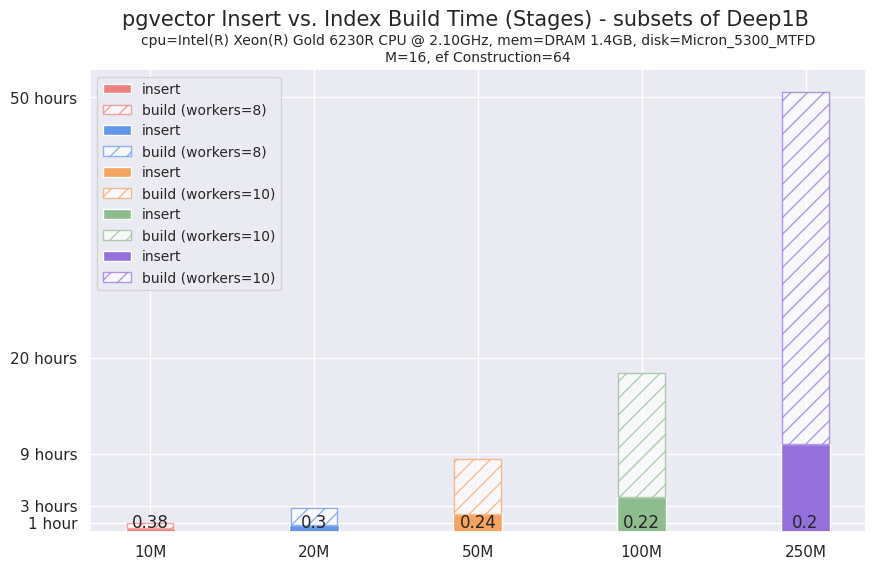

In [9]:
# stacked 
# pgvector insert vs index build

import seaborn as sns

# data
# 10m
insert_1 = np.array([1455.804854])
build_1 = np.array([3787.477359-1455.804854])

# 20m
insert_2 = np.array([3002.124852])
build_2 = np.array([9898.810132-3002.124852])

# 50m
insert_3 = np.array([7313.530771])
build_3 = np.array([29977.998475-7313.530771])

# 100m
insert_4 = np.array([14609.566409])
build_4 = np.array([65876.278206-14609.566409])

# 250m
insert_5 = np.array([36580.73947])
build_5 = np.array([182289.052372-36580.73947])


# data sizes
sizes = ['10M', '20M', '50M', '100M', '250M']
percent = [round(1455.804854/3787.477359, 2), round(3002.124852/9898.810132, 2), round(7313.530771/29977.998475, 2), \
    round(14609.566409/65876.278206, 2), round(36580.73947/182289.052372, 2)]

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.3
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    v_pos = np.arange(1)
    gxl_pos = v_pos + bar_width
    gxl_8_pos = gxl_pos + bar_width
    gxl_15_pos = gxl_8_pos + bar_width

    stacked_11 = plt.bar(sizes[0], insert_1, bar_width, color='lightcoral', label='insert')

    stacked_12 = plt.bar(sizes[0], build_1, bar_width-epsilon, 
                            bottom=insert_1, alpha=opacity, color='white', edgecolor='lightcoral',
                            linewidth=line_width, hatch='//', label='build (workers=8)')


    stacked_21 = plt.bar(sizes[1], insert_2, bar_width, color='cornflowerblue', label='insert')

    stacked_22 = plt.bar(sizes[1], build_2, bar_width-epsilon, 
                            bottom=insert_2, alpha=opacity, color='white', edgecolor='cornflowerblue',
                            linewidth=line_width, hatch='//', label='build (workers=8)')


    stacked_31 = plt.bar(sizes[2], insert_3, bar_width, color='sandybrown', label='insert')

    stacked_32 = plt.bar(sizes[2], build_3, bar_width-epsilon, 
                            bottom=insert_3, alpha=opacity, color='white', edgecolor='sandybrown',
                            linewidth=line_width, hatch='//', label='build (workers=10)')


    stacked_41 = plt.bar(sizes[3], insert_4, bar_width, color='darkseagreen', label='insert')

    stacked_42 = plt.bar(sizes[3], build_4, bar_width-epsilon, 
                            bottom=insert_4, alpha=opacity, color='white', edgecolor='darkseagreen',
                            linewidth=line_width, hatch='//', label='build (workers=10)')

    stacked_51 = plt.bar(sizes[4], insert_5, bar_width, color='mediumpurple', label='insert')

    stacked_52 = plt.bar(sizes[4], build_5, bar_width-epsilon, 
                            bottom=insert_5, alpha=opacity, color='white', edgecolor='mediumpurple',
                            linewidth=line_width, hatch='//', label='build (workers=10)')
    
    # function to add value labels
    def addlabels(x, y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha='center', va='bottom')

    addlabels(sizes, percent)

    plt.xticks(np.arange(5), sizes)
    plt.yticks([ 3600, 10800, 32400, 72000, 180000 ], ['1 hour', '3 hours', '9 hours', '20 hours', '50 hours'])
    plt.legend(loc='best', fontsize=10)
    sns.despine()

    plt.suptitle('pgvector Insert vs. Index Build Time (Stages) - subsets of Deep1B', fontsize=15)
    plt.title('cpu=Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz, mem=DRAM 1.4GB, disk=Micron_5300_MTFD\nM=16, ef Construction=64', fontsize=10)

    plt.savefig('results/vis/pgvector_insert_index_build.png', bbox_inches="tight")
    plt.show()

In [1]:
from datetime import datetime

fmt = '%Y-%m-%d %H:%M:%S'
tstamp1 = datetime.strptime('2024-05-09 08:56:42', fmt)
tstamp2 = datetime.strptime('2024-05-09 19:39:50', fmt)

if tstamp1 > tstamp2:
    td = tstamp1 - tstamp2
else:
    td = tstamp2 - tstamp1
td_mins = td.total_seconds()

print('The difference is approx. %s secs' % td_mins)

The difference is approx. 38588.0 secs


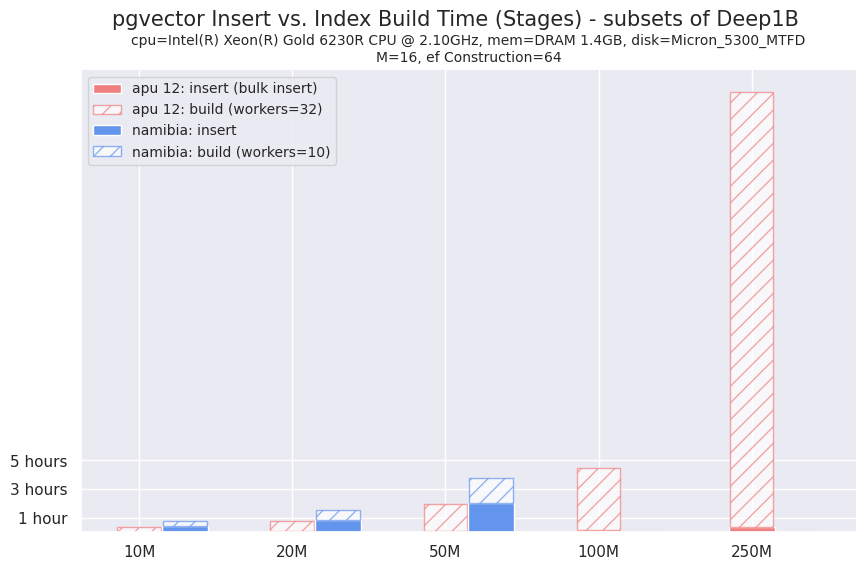

In [8]:
# stacked 
# pgvector insert vs index build

import seaborn as sns
# 10, 20, 50, 100, 250

# data
# apu 12
insert_1 = np.array([1455.804854, 3002.124852, 7313.530771, 14609.566409, 36580.73947])
build_1 = np.array([3787.477359-1455.804854, 9898.810132-3002.124852, 29977.998475-7313.530771, \
    65876.278206-14609.566409, 182289.052372-36580.73947])

# namibia
insert_2 = np.array([1466.91564, 3039.423637, 7340.483593, 0, 0])
build_2 = np.array([1152, 2388, 6331, 0, 0])

"""# apu12 - 10 workers 0.6.2 100gb
# 10m, 20m, 50m
insert_3 = [1463.885893, ]
build_3 = [1267, ]"""

"""# apu12 - 32 workers 0.6.2 100gb
# 10m, 20m, 50m, 100m, 250m
insert_3 = [1460.18156, 2915.48028, 7283.138524, 14573.505349, 36438.028897]
build_3 = [1328, 2879, 7661, 14670, 105627]"""

# apu12 - 32 workers, 0.6.2, 100gb, bulk load
insert_5 = [51.830191, 102.529959, 251.839579, 515.305996, 1336.106332]
build_5 = [1272, 2663, 6776, 15565, 109650]



# data sizes
sizes = ['10M', '20M', '50M', '100M', '250M']
#percent = [round(1455.804854/3787.477359, 2), round(3002.124852/9898.810132, 2), round(7313.530771/29977.998475, 2), \
    #round(14609.566409/65876.278206, 2), round(36580.73947/182289.052372, 2)]

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.3
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    v_pos = np.arange(len(insert_1))
    gxl_pos = v_pos + bar_width
    gxl_8_pos = gxl_pos + bar_width
    gxl_15_pos = gxl_8_pos + bar_width

    stacked_11 = plt.bar(v_pos, insert_5, bar_width, color='lightcoral', label='apu 12: insert (bulk insert)')

    stacked_12 = plt.bar(v_pos, build_5, bar_width-epsilon, 
                            bottom=insert_5, alpha=opacity, color='white', edgecolor='lightcoral',
                            linewidth=line_width, hatch='//', label='apu 12: build (workers=32)')


    stacked_21 = plt.bar(gxl_pos, insert_2, bar_width, color='cornflowerblue', label='namibia: insert')

    stacked_22 = plt.bar(gxl_pos, build_2, bar_width-epsilon, 
                            bottom=insert_2, alpha=opacity, color='white', edgecolor='cornflowerblue',
                            linewidth=line_width, hatch='//', label='namibia: build (workers=10)')


    """for i in range(len(ax.patches)):
        # 0, 1
        for i in [0, 1, 2, 3, 4]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/3600, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

        # 2, 3
        for i in [5, 6, 7]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/60, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')"""

    
    # function to add value labels
    def addlabels(x, y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha='center', va='bottom')

    #addlabels(sizes, percent)

    plt.xticks(np.arange(5), sizes)
    #plt.yticks([ 3600, 10800, 32400, 72000, 180000 ], ['1 hour', '3 hours', '9 hours', '20 hours', '50 hours'])
    plt.yticks([ 3600, 10800, 18000 ], ['1 hour', '3 hours', '5 hours'])
    plt.legend(loc='best', fontsize=10)
    sns.despine()

    plt.suptitle('pgvector Insert vs. Index Build Time (Stages) - subsets of Deep1B', fontsize=15)
    plt.title('cpu=Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz, mem=DRAM 1.4GB, disk=Micron_5300_MTFD\nM=16, ef Construction=64', fontsize=10)

    plt.savefig('results/vis/pgvector_insert_index_build.png', bbox_inches="tight")
    plt.show()

In [7]:
insert_5 = [51.830191, 102.529959, 251.839579, 515.305996, 1336.106332]
build_5 = [1272, 2663, 6776, 15565, 38588]
lst = []
for i in range(len(insert_5)):
    x = insert_5[i] + build_5[i]
    lst.append(x)

lst

[1323.830191, 2765.529959, 7027.839579, 16080.305996, 39924.106332]

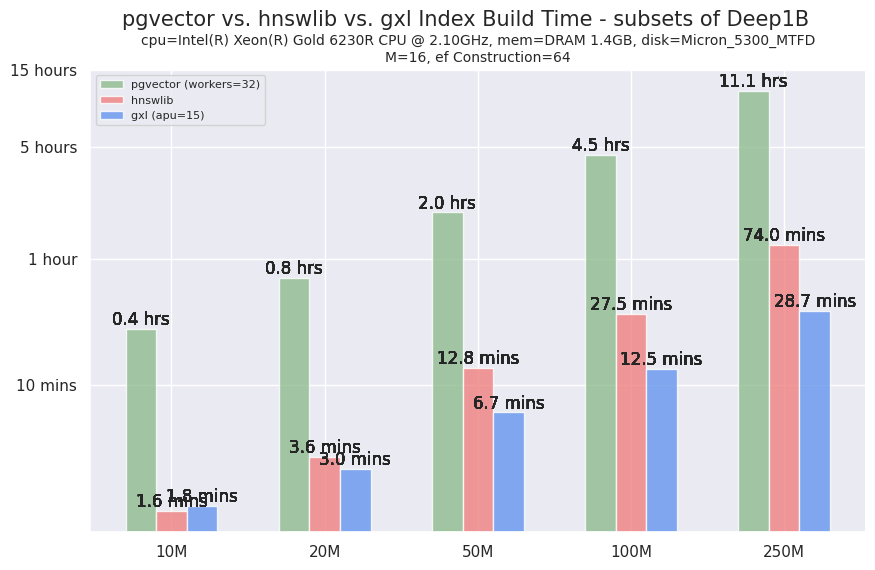

In [8]:
import seaborn as sns

# data
#pg_lst = [2788, 5794, 14944, 29252, 142065]
pg_lst = [1323.830191, 2765.529959, 7027.839579, 16080.305996, 39924.106332]

# hnswlib vanilla
hnswlib_lst = [98.77, 213.45, 766.100065, 1647.98, 4441.59]

# gxl: 15 apu
gxl_lst = [106.1, 179.34, 403.191211, 749.99, 1720.91]

t1 = np.array(pg_lst)
t2 = np.array(hnswlib_lst)
t3 = np.array(gxl_lst)

# data sizes
sizes = ['10M', '20M', '50M', '100M', '250M']

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.2
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    
    pos1 = np.arange(len(t1))
    pos2 = pos1 + bar_width
    pos3 = pos2 + bar_width

    fig, ax = plt.subplots()
    plt.yscale("log") 

    b1 = plt.bar(pos1, t1, bar_width, color='darkseagreen', label='pgvector (workers=32)', alpha=0.8)
    b2 = plt.bar(pos2, t2, bar_width, color='lightcoral', label='hnswlib', alpha=0.8)
    b3 = plt.bar(pos3, t3, bar_width, color='cornflowerblue', label='gxl (apu=15)', alpha=0.8)
    
    for i in range(len(ax.patches)):
        # 0, 1
        for i in [0, 1, 2, 3, 4]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/3600, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} hrs'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

        # 2, 3
        for i in [5, 6, 7, 8, 9]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/60, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

        # 4, 5
        for i in [10, 11, 12, 13, 14]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/60, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')


    plt.xticks(pos2, sizes)
    #plt.yticks([ 600, 3600, 18000, 28800, 144000 ], ['10 mins', '1 hour', '5 hours', '8 hours', '40 hours'])
    plt.yticks([ 600, 3600, 18000, 36000 ], ['10 mins', '1 hour', '5 hours', '10 hours'])
    plt.legend(loc='upper left', fontsize=8)
    sns.despine()

    plt.suptitle('pgvector vs. hnswlib vs. gxl Index Build Time - subsets of Deep1B', fontsize=15)
    plt.title('cpu=Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz, mem=DRAM 1.4GB, disk=Micron_5300_MTFD\nM=16, ef Construction=64', fontsize=10)

    plt.savefig('results/vis/pgvector_hnswlib_gxl_index_build_time_total.png', bbox_inches="tight")
    plt.show()

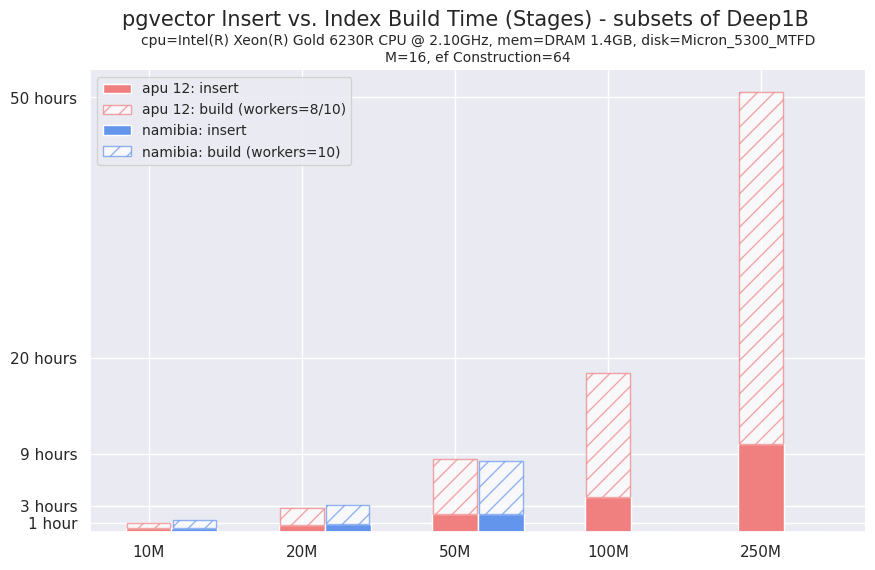

In [24]:
# stacked old
# pgvector insert vs index build

import seaborn as sns

# data
# apu 12
insert_1 = np.array([1455.804854, 3002.124852, 7313.530771, 14609.566409, 36580.73947])
build_1 = np.array([3787.477359-1455.804854, 9898.810132-3002.124852, 29977.998475-7313.530771, \
    65876.278206-14609.566409, 182289.052372-36580.73947])

# namibia
# 10, 20, 50
insert_2 = np.array([1466.91564, 3039.423637, 7340.483593, 0, 0])
build_2 = np.array([3519, 8104, 21862, 0, 0])



# data sizes
sizes = ['10M', '20M', '50M', '100M', '250M']
#percent = [round(1455.804854/3787.477359, 2), round(3002.124852/9898.810132, 2), round(7313.530771/29977.998475, 2), \
    #round(14609.566409/65876.278206, 2), round(36580.73947/182289.052372, 2)]

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    # plot details
    bar_width = 0.3
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    v_pos = np.arange(len(insert_1))
    gxl_pos = v_pos + bar_width
    gxl_8_pos = gxl_pos + bar_width
    gxl_15_pos = gxl_8_pos + bar_width

    stacked_11 = plt.bar(v_pos, insert_1, bar_width, color='lightcoral', label='apu 12: insert')

    stacked_12 = plt.bar(v_pos, build_1, bar_width-epsilon, 
                            bottom=insert_1, alpha=opacity, color='white', edgecolor='lightcoral',
                            linewidth=line_width, hatch='//', label='apu 12: build (workers=8/10)')


    stacked_21 = plt.bar(gxl_pos, insert_2, bar_width, color='cornflowerblue', label='namibia: insert')

    stacked_22 = plt.bar(gxl_pos, build_2, bar_width-epsilon, 
                            bottom=insert_2, alpha=opacity, color='white', edgecolor='cornflowerblue',
                            linewidth=line_width, hatch='//', label='namibia: build (workers=10)')


    for i in range(len(ax.patches)):
        # 0, 1
        for i in [0, 1, 2, 3, 4]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/3600, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

        # 2, 3
        for i in [5, 6, 7]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/60, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

    
    # function to add value labels
    def addlabels(x, y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha='center', va='bottom')

    #addlabels(sizes, percent)

    plt.xticks(np.arange(5), sizes)
    plt.yticks([ 3600, 10800, 32400, 72000, 180000 ], ['1 hour', '3 hours', '9 hours', '20 hours', '50 hours'])
    plt.legend(loc='best', fontsize=10)
    sns.despine()

    plt.suptitle('pgvector Insert vs. Index Build Time (Stages) - subsets of Deep1B', fontsize=15)
    plt.title('cpu=Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz, mem=DRAM 1.4GB, disk=Micron_5300_MTFD\nM=16, ef Construction=64', fontsize=10)

    plt.savefig('results/vis/pgvector_insert_index_build.png', bbox_inches="tight")
    plt.show()

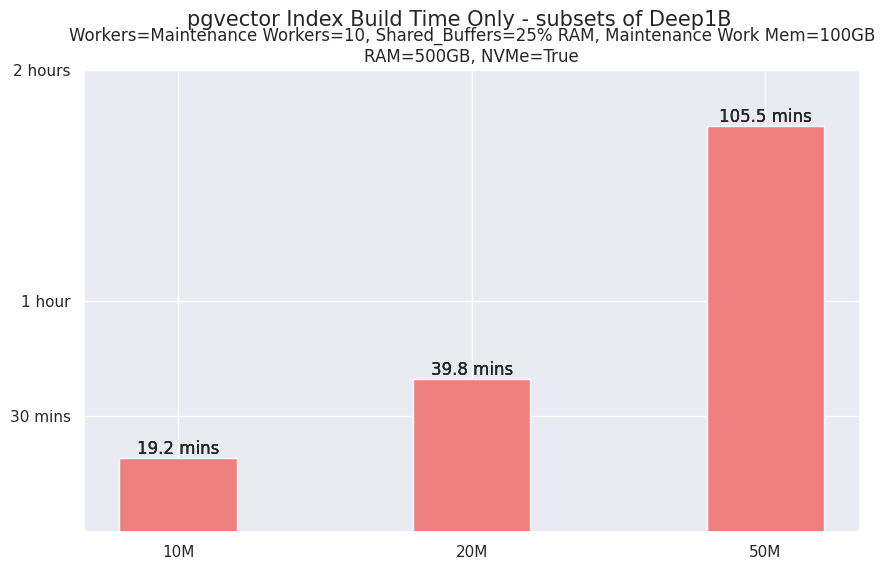

In [6]:
# stacked 
# pgvector insert vs index build

import seaborn as sns

# data
# apu 12
insert_1 = np.array([1455.804854, 3002.124852, 7313.530771])
build_1 = np.array([3787.477359-1455.804854, 9898.810132-3002.124852, 29977.998475-7313.530771])

# namibia
# 10, 20, 50
insert_2 = np.array([1466.91564, 3039.423637, 7340.483593])
build_2 = np.array([1152, 2388, 6331])



# data sizes
sizes = ['10M', '20M', '50M']
t = [round(i/60, 1) for i in build_2]

#percent = [round(1455.804854/3787.477359, 2), round(3002.124852/9898.810132, 2), round(7313.530771/29977.998475, 2), \
    #round(14609.566409/65876.278206, 2), round(36580.73947/182289.052372, 2)]

with sns.axes_style("white"):
    sns.set_style("ticks")
    sns.set_context("talk")
    sns.set(rc={'figure.figsize':(10, 6)})

    fig, ax = plt.subplots()

    # plot details
    bar_width = 0.4
    epsilon = 0.015
    line_width = 1
    opacity = 0.7
    v_pos = np.arange(len(insert_1))
    gxl_pos = v_pos + bar_width
    gxl_8_pos = gxl_pos + bar_width
    gxl_15_pos = gxl_8_pos + bar_width

    stacked_11 = plt.bar(v_pos, build_2, bar_width, color='lightcoral', label='workers=10')

    """stacked_12 = plt.bar(v_pos, build_1, bar_width-epsilon, 
                            bottom=insert_1, alpha=opacity, color='white', edgecolor='lightcoral',
                            linewidth=line_width, hatch='//', label='apu 12: build (workers=8/10)')
"""

    #stacked_21 = plt.bar(gxl_pos, build_2, bar_width, color='cornflowerblue', label='namibia: build (workers=10)')

    """stacked_22 = plt.bar(gxl_pos, build_2, bar_width-epsilon, 
                            bottom=insert_2, alpha=opacity, color='white', edgecolor='cornflowerblue',
                            linewidth=line_width, hatch='//', label='namibia: build (workers=10)')
"""

    for i in range(len(ax.patches)):
        # 0, 1
        for i in [0, 1, 2]:
            patch = ax.patches[i]
            lbl = round(patch.get_height()/60, 1)
            ax.text(patch.get_x() + patch.get_width()/2, patch.get_height(), '{} mins'.format(lbl), 
            verticalalignment='bottom', horizontalalignment='center')

    
    # function to add value labels
    def addlabels(x, y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], verticalalignment='bottom', horizontalalignment='center')

    #addlabels(sizes, t)

    plt.xticks(np.arange(3), sizes)
    plt.yticks([ 1800, 3600, 7200 ], ['30 mins', '1 hour', '2 hours'])
    #plt.legend(loc='upper left', fontsize=10)
    sns.despine()

    plt.suptitle('pgvector Index Build Time Only - subsets of Deep1B', fontsize=15)
    #plt.title('cpu=Intel(R) Xeon(R) Gold 6230R CPU @ 2.10GHz, mem=DRAM 1.4GB, disk=Micron_5300_MTFD\nM=16, ef Construction=64', fontsize=10)
    plt.title('Workers=Maintenance Workers=10, Shared_Buffers=25% RAM, Maintenance Work Mem=100GB\nRAM=500GB, NVMe=True')

    plt.savefig('results/vis/pgvector_index_build_only.png', bbox_inches="tight")
    plt.show()